Imports

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

In [21]:
df = pd.read_csv('../data/Walmart_Sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Preprocess dataframe

In [23]:
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date')

In [24]:
# List of years
loy = []
def month_to_season(month):
    if month in ['03', '04', '05',]:
        return 'spring'
    elif month in ['06', '07', '08']:
        return 'summer'
    elif month in ['09', '10', '11']:
        return 'fall'
    else:
        return 'winter'
for dt in df['date']:
    loy.append(month_to_season(dt.strftime("%m")))
df['season'] = loy

In [25]:
df.duplicated().sum()

0

In [26]:
df.shape
df.describe()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


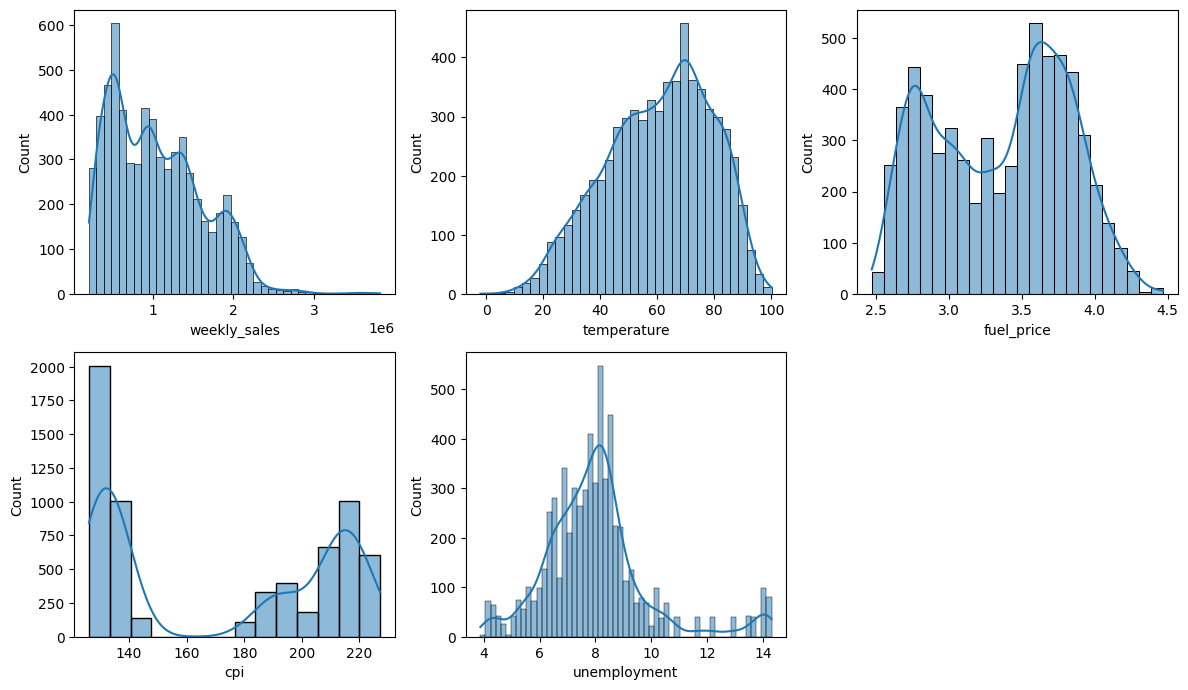

In [27]:
features = ['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']

plt.figure(figsize=(12, 10))

for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    
    sns.histplot(data=df, x=col, kde=True)

plt.tight_layout()
plt.show()

Feature correlation

/var/folders/rs/wtw7v0gd2cn68ztrym0zq6d80000gn/T/ipykernel_82649/1963757295.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


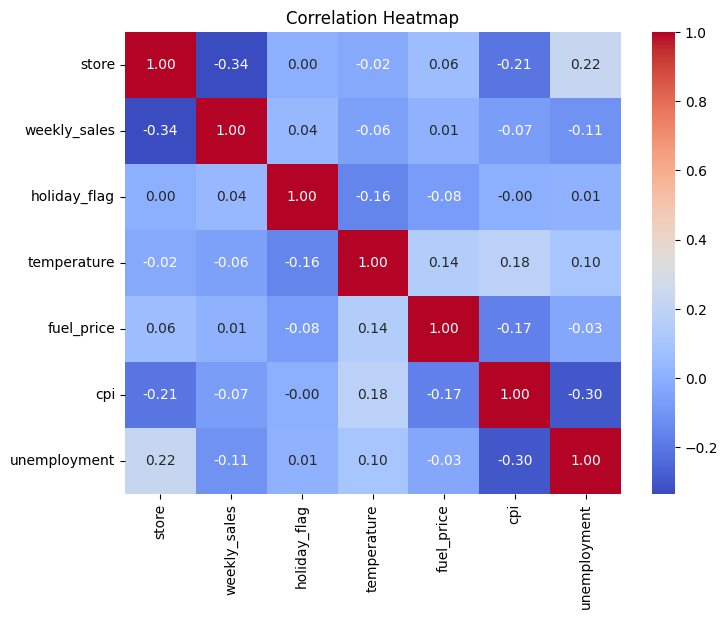

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Visualize sales by season

<Figure size 1200x600 with 0 Axes>

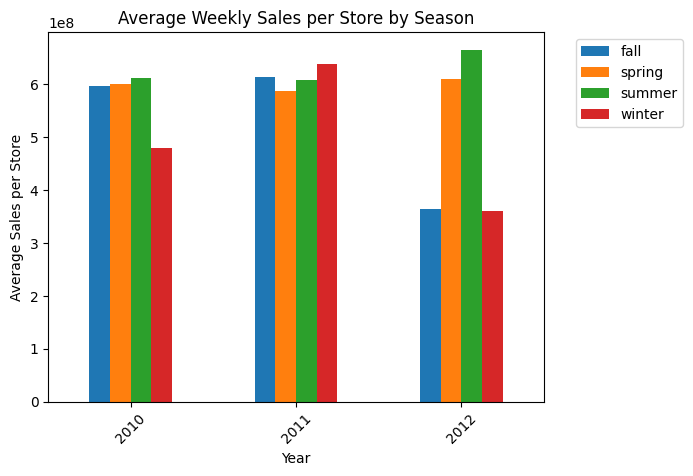

In [29]:
df['year'] = df['date'].dt.year
df_total = df.groupby(['year', 'season'])['weekly_sales'].sum().unstack()

plt.figure(figsize=(12,6))
df_total.plot(kind='bar')
plt.title('Average Weekly Sales per Store by Season')
plt.ylabel('Average Sales per Store')
plt.legend(bbox_to_anchor = (1.05, 1))
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.show()

Visualize the weekly sales for each store

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


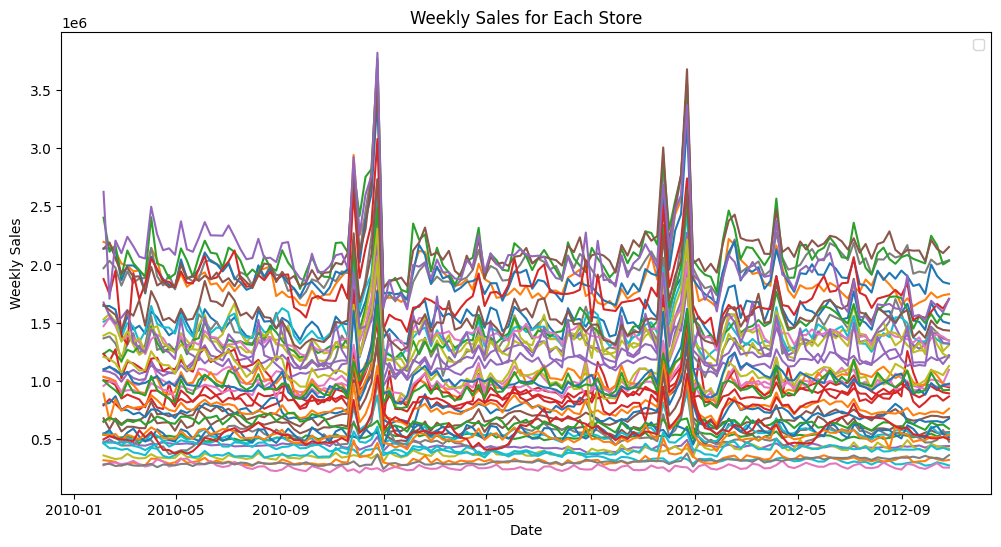

In [30]:
plt.figure(figsize=(12, 6))
for store in df['store'].unique():
    store_date = df[df['store'] == store]
    plt.plot(store_date['date'], store_date['weekly_sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Each Store')
plt.legend()
plt.show()



It seems that there is seasonality within the data as we see small bumps and we also see what seems to be 2 change poitns in the data where the sales for each store spike.

We will group all data and sum up all store sales into 1 value as it seems as if all stores follow the same seasonal trend (sales go up and down at the same time)

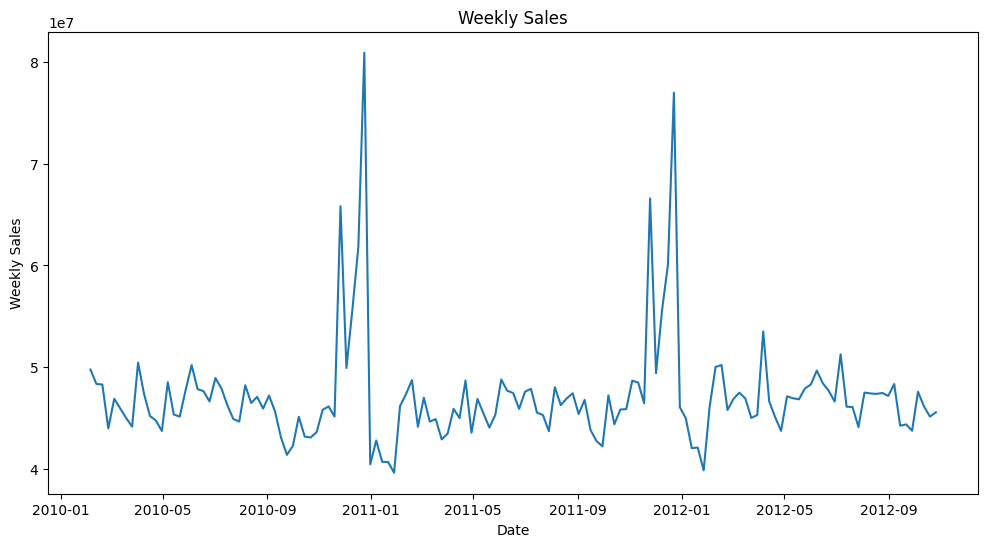

In [31]:
week_total = df.groupby('date').agg({
    'weekly_sales': 'sum',
    'holiday_flag': 'max'
}).reset_index().sort_values('date')
plt.figure(figsize=(12, 6))
plt.plot(week_total['date'], week_total['weekly_sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales')
plt.show()

From the weekly_sales we can predict that there is a spike in sales around november and december every year since it is around thanksgiving and christmas in the united states.

In [32]:
# saving grouped weekly_sales data in a new dataframe
# agg_rules = {
#     'weekly_sales': 'sum',         
#     'holiday_flag': 'max',  
#     'temperature' : 'mean',      
#     'cpi': 'mean',                
#     'unemployment': 'mean',      
# }

# weekly_df = df.groupby('date').agg(agg_rules).reset_index()
# weekly_df.to_csv('Grouped_Walmart_Sales.csv', index=False)

Perform a decomposition to find underlying trends, seasonality and noise. We must observe if the noise is stationary or other implicit features of the data

In [33]:
week_total = week_total.set_index('date')

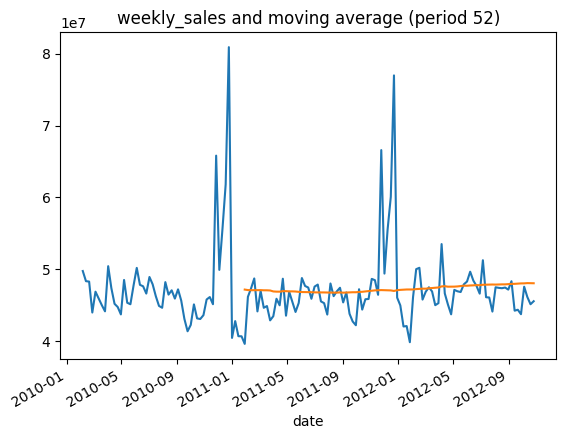

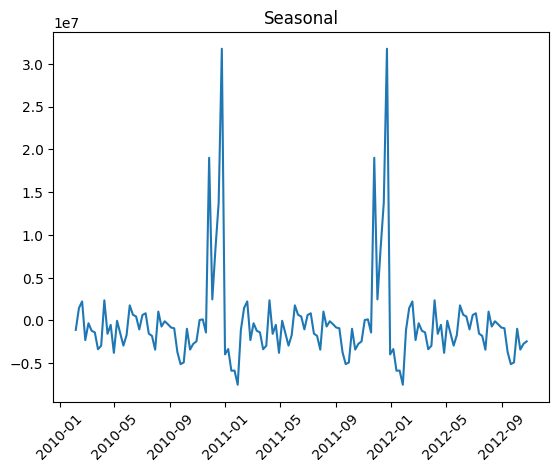

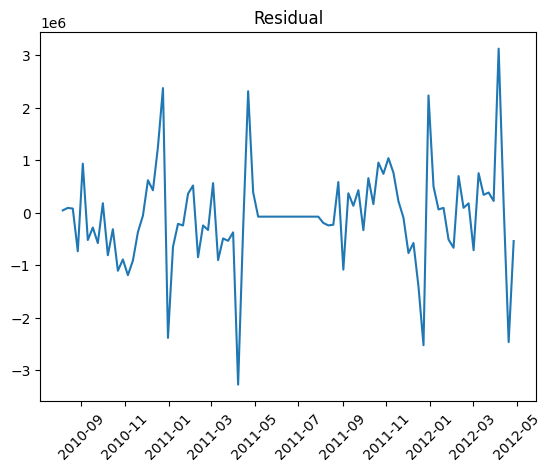

In [34]:
decomposition = seasonal_decompose(week_total['weekly_sales'], period = 52)

# Plot trend (moving average) and plot moving std
plt.plot(week_total['weekly_sales'])
week_total['weekly_sales'].rolling(window=52).mean().plot(title = 'weekly_sales and moving average (period 52)')
plt.show()

# Plot seasonal
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=45)
plt.show()

# Plot residual
plt.plot(decomposition.resid)
plt.title('Residual')
plt.xticks(rotation=45)
plt.show()

Based off of the decomposition we can see that in the moving average there does not appear to be a clear trend which provides evidence for the data being stationary. Also observing the seasonality, it does not appear to have any clear patterns in time when the weekly_sales go up and down which also provides evidence for the data being stationary. On the other hand when we observe the residuals, it appears to have a non constant variance as some parts have the residuals at a smaller variance and others at a higher variance which provides evidence against the data being stationary and also may hinder forecasting.

To follow up off of the previous observation of stationarity of the data we will perform an AD-Fuller test. The alternative hypothesis of the test being that the data is stationary.

In [35]:
adfuller_test = adfuller(week_total['weekly_sales'])
print("p-value:", adfuller_test[1])

p-value: 2.6759791589860825e-07


Now given that our data is stationary we will forecast sales with many models and compare.